# Main - Charcrete LCA

## 1. Set the project and import Charcrete database

In [4]:
# === Switch to kernel bw25! ===

# Brightway libraries
import bw2data as bd
import bw2io as bi
import bw2calc as bc
import bw2analyzer as ba
import bw_processing as bwp

# General libraries
import numpy as np
import pandas as pd
from fs.zipfs import ZipFS
import json                        # Library for working with json files
from pathlib import Path           # Library for working with paths in different OS     
import matplotlib.pyplot as plt    # Library for creating plots
import os

# Our own functions
%run utils.ipynb

In [5]:
bd.projects.set_current("ei38-teaching-25")

In [6]:
wdir = os.getcwd()

### Importing Charcrete database Excel-file

In [7]:
if "Charcrete_38" in bd.databases:
    del bd.databases["Charcrete_38"]

# 1. Specify filepath to your foreground inventories.
charcrete_path = wdir+"/data/Charcrete_database_38.xlsx"
#charcrete_path = "/home/jupyter-mija.frossard/Charcrete-LCA/Water_database_38.xlsx"
# 2. Create an instance of a class that contains basic methods for importing a database from an excel file.
charcrete = bi.ExcelImporter(charcrete_path)  
# 3. `apply_strategies` is one of such basic methods, it makes sure units, locations, etc are in correct format.
charcrete.apply_strategies()
# 4. Next step is to link your foreground exchanges to existing databases by matching relevant exchanges fields.
charcrete.match_database("biosphere3", fields=("name", "unit", "categories"))
charcrete.match_database("ei 3.8 cutoff", fields=("name", "location", "unit"))
#charcrete.metadata.pop(None)  # Remove metadata None entry. TODO
# 5. If everything is linked, write database so that it is saved in your project.
if charcrete.all_linked:
    charcrete.write_database()

Extracted 2 worksheets in 0.01 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list
Applied 16 strategies in 7.22 seconds
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
7 datasets
43 exchanges
0 unlinked exchanges
  
Title: Writing activities to SQLite3 da

In [8]:
for unlinked in charcrete.unlinked:
    print(unlinked)

In [9]:
bd.databases

Databases dictionary with 7 object(s):
	Charcrete_38
	EXIOBASE 3.8.1 2017 monetary
	EXIOBASE 3.8.1 2017 monetary biosphere
	Korean Motors Chaebol
	Water_38
	biosphere3
	ei 3.8 cutoff

In [10]:
len(bd.Database("Charcrete_38"))

7

## 2. Basic calculations and comparisons

In [11]:
bd.projects.set_current("ei38-teaching-25")

In [12]:
char_db = bd.Database("Charcrete_38")

In [13]:
ei_db = bd.Database("ei 3.8 cutoff")

In [14]:
charcrete = [act for act in char_db if "Charcrete production 5%" in act["name"]][0]
charcrete_7 = [act for act in char_db if "Charcrete production 7.5%" in act["name"]][0]
charcrete_10 = [act for act in char_db if "Charcrete production 10%" in act["name"]][0]
charcrete

'Charcrete production 5%' (cubic meter, SE, None)

In [15]:
concrete_ei = [act for act in ei_db if "concrete production 20MPa" in act["name"]]
concrete_ei

['concrete production 20MPa' (cubic meter, CA-QC, None),
 'concrete production 20MPa' (cubic meter, RoW, None),
 'concrete production 20MPa' (cubic meter, ZA, None),
 'concrete production 20MPa' (cubic meter, North America without Quebec, None)]

#### Choice of an LCIA method: IPCC 2013 GWP 100

In [16]:
ipcc = ('IPCC 2013', 'climate change', 'GWP 100a')
method = bd.Method(ipcc)

#### Analysis of standard concrete production

In [17]:
concretes_gwp = [calculateLCA(act, 1, ipcc) for act in concrete_ei]

'concrete production 20MPa' (cubic meter, CA-QC, None) 234.1879918934279
'concrete production 20MPa' (cubic meter, RoW, None) 193.85391050515568
'concrete production 20MPa' (cubic meter, ZA, None) 229.71912735575845
'concrete production 20MPa' (cubic meter, North America without Quebec, None) 217.55243665066354


In [18]:
first_lca = pd.DataFrame(list(zip([act["name"] for act in concrete_ei],[act["location"] for act in concrete_ei], concretes_gwp)), columns=["activity", "location", "GWP"])
first_lca

,activity,location,GWP
0,concrete production 20MPa,CA-QC,234.187992
1,concrete production 20MPa,RoW,193.853911
2,concrete production 20MPa,ZA,229.719127
3,concrete production 20MPa,North America without Quebec,217.552437


In [19]:
best_concrete_idx = first_lca[['GWP']].idxmin()[0]
worst_concrete_idx = first_lca[['GWP']].idxmax()[0]

In [20]:
ba.print_recursive_calculation(concrete_ei[best_concrete_idx], ipcc, cutoff=0.010)

Fraction of score | Absolute score | Amount | Activity
0001 | 193.9 |     1 | 'concrete production 20MPa' (cubic meter, RoW, None)
  0.0214 | 4.153 | 858.8 | 'market for gravel, round' (kilogram, CH, None)
    0.0118 | 2.283 |  17.4 | 'market for transport, freight, lorry, unspecified' (ton kilometer, RE
  0.839 | 162.6 | 256.6 | 'market for cement, portland fly ash cement 21-35%' (kilogram, RoW, No
    00.8 |   155 | 256.6 | 'cement production, fly ash 21-35%' (kilogram, RoW, None)
      0.0296 | 5.739 | 6.118 | 'market group for electricity, medium voltage' (kilowatt hour, RAS, No
      0.146 | 28.27 | 30.21 | 'market for clinker' (kilogram, Europe without Switzerland, None)
      0.0303 | 5.868 | 6.363 | 'market for clinker' (kilogram, BR, None)
      0.129 | 24.98 | 28.23 | 'market for clinker' (kilogram, IN, None)
      0.43 | 83.42 | 90.59 | 'market for clinker' (kilogram, RoW, None)
    0.0318 | 6.173 | 44.72 | 'market for transport, freight, lorry, unspecified' (ton kilometer, 

In [21]:
ba.print_recursive_calculation(concrete_ei[worst_concrete_idx], ipcc, cutoff=0.010)

Fraction of score | Absolute score | Amount | Activity
0001 | 234.2 |     1 | 'concrete production 20MPa' (cubic meter, CA-QC, None)
  0.0483 |  11.3 |   950 | 'market for sand' (kilogram, RoW, None)
    0.0181 | 4.235 | 30.68 | 'market for transport, freight, lorry, unspecified' (ton kilometer, Ro
    0.0121 | 2.824 | 672.1 | 'gravel and sand quarry operation' (kilogram, RoW, None)
  0.0477 | 11.17 | 960.1 | 'market for gravel, round' (kilogram, RoW, None)
    0.0172 | 4.034 | 960.1 | 'gravel and sand quarry operation' (kilogram, RoW, None)
    0.0159 | 3.714 | 26.91 | 'market for transport, freight, lorry, unspecified' (ton kilometer, Ro
  0.878 | 205.6 | 239.5 | 'market for cement, Portland' (kilogram, CA-QC, None)
    0.0151 | 3.534 |  25.6 | 'market for transport, freight, lorry, unspecified' (ton kilometer, Ro
    0.855 | 200.2 | 239.5 | 'cement production, Portland' (kilogram, CA-QC, None)
      0.85 |   199 | 220.4 | 'clinker production' (kilogram, CA-QC, None)


Concrete with the least impact has "market for cement, portland fly ash cement 21-35%, RoW"

In [101]:
concrete_ei = [concrete_ei+charcrete+charcrete_7+charcrete_10
first_lca = pd.DataFrame(list(zip([act["name"] for act in concrete_ei],[act["location"] for act in concrete_ei], concretes_gwp)), columns=["activity", "location", "GWP"])
first_lca

TypeError: can only concatenate list (not "Activity") to list

#### Analysis over the cement production

In [22]:
cement = [act for act in ei_db if 'market for cement,' in act["name"] and "kilogram" in act["unit"]]

In [23]:
#cement_gwp = [calculateLCA(act, 1, ipcc) for act in cement]
fu, data_objs, _ = bd.prepare_lca_inputs({cement[0]: 1}, method=ipcc)
lca = bc.LCA(fu, data_objs=data_objs)
lca.lci()
lca.lcia()
results_ciment = []
for act in cement:
    lca.redo_lcia({act.id: 1})
    results_ciment.append((act["name"], act["location"], lca.score))

cements_lca = pd.DataFrame(results_ciment, columns=["activity", "location", "GWP"])
cements_lca.to_csv(wdir+"/outputs/gwp_results_cement_1_kg.csv")
cements_lca

,activity,location,GWP
0,"market for cement, blast furnace slag 5-25%",US,0.838301
1,"market for cement, Portland",Europe without Switzerland,0.875039
2,"market for cement, limestone 6-20%",RoW,0.765027
3,"market for cement, unspecified",PE,0.771636
4,"market for cement, Portland",CA-QC,0.858444
...,...,...,...
93,"market for cement, blast furnace slag 70-100%",US,0.323796
94,"market for cement, blast furnace slag 5-25%",RoW,0.832965
95,"market for cement, blast furnace slag 66-80%",RoW,0.443241
96,"market for cement, pozzolana and fly ash 5-15%",US,0.857438


In [24]:
cements_lca.nunique()

activity    32
location    10
GWP         98
dtype: int64

#### Adding the charcrete to the comparison

In [25]:
concrete_ei = [*concrete_ei, charcrete, charcrete_7, charcrete_10]
print(concrete_ei)
concretes_gwp = [calculateLCA(act, 1, ipcc) for act in concrete_ei]

['concrete production 20MPa' (cubic meter, CA-QC, None), 'concrete production 20MPa' (cubic meter, RoW, None), 'concrete production 20MPa' (cubic meter, ZA, None), 'concrete production 20MPa' (cubic meter, North America without Quebec, None), 'Charcrete production 5%' (cubic meter, SE, None), 'Charcrete production 7.5%' (cubic meter, SE, None), 'Charcrete production 10%' (cubic meter, SE, None)]
'concrete production 20MPa' (cubic meter, CA-QC, None) 234.1879918934279
'concrete production 20MPa' (cubic meter, RoW, None) 193.85391050515568
'concrete production 20MPa' (cubic meter, ZA, None) 229.71912735575845
'concrete production 20MPa' (cubic meter, North America without Quebec, None) 217.55243665066354
'Charcrete production 5%' (cubic meter, SE, None) 177.6456230224958
'Charcrete production 7.5%' (cubic meter, SE, None) 173.5558197613203
'Charcrete production 10%' (cubic meter, SE, None) 169.37472406675374


In [26]:
first_lca = pd.DataFrame(list(zip([act["name"] for act in concrete_ei],[act["location"] for act in concrete_ei], concretes_gwp)), columns=["activity", "location", "GWP"])
first_lca.to_csv(wdir+"/outputs/first_lca_results_concrete_1_m3.csv")
first_lca

,activity,location,GWP
0,concrete production 20MPa,CA-QC,234.187992
1,concrete production 20MPa,RoW,193.853911
2,concrete production 20MPa,ZA,229.719127
3,concrete production 20MPa,North America without Quebec,217.552437
4,Charcrete production 5%,SE,177.645623
5,Charcrete production 7.5%,SE,173.555820
6,Charcrete production 10%,SE,169.374724


In [27]:
ba.print_recursive_calculation(charcrete, ipcc, cutoff=0.010)

Fraction of score | Absolute score | Amount | Activity
0001 | 177.6 |     1 | 'Charcrete production 5%' (cubic meter, SE, None)
  0.0123 | 2.184 |  0.01 | 'Biochar production' (ton, SE, None)
  0.0346 | 6.151 |  1000 | 'market for gravel, crushed' (kilogram, CH, None)
    0.015 | 2.659 | 20.26 | 'market for transport, freight, lorry, unspecified' (ton kilometer, RE
    0.0194 | 3.437 |  1000 | 'gravel production, crushed' (kilogram, CH, None)
  0.0255 | 4.536 |   938 | 'market for sand' (kilogram, CH, None)
    0.014 | 2.494 |    19 | 'market for transport, freight, lorry, unspecified' (ton kilometer, RE
    0.0112 | 1.991 |   938 | 'gravel and sand quarry operation' (kilogram, CH, None)
  0.024 | 4.261 |   3.2 | 'market for plasticiser, for concrete, based on sulfonated melamine fo
    0.0231 |   4.1 |   3.2 | 'plasticiser production, for concrete, based on sulfonated melamine fo
      0.0121 | 2.147 | 1.075 | 'market for chemical, organic' (kilogram, GLO, None)
  0.92 | 163.5 | 186.8

**Charcrete** is not that good I guess... Need to investigate the formulation of the concrete and other parameters with more data/uncertainty analysis on : 
- cement production process and localisation
- formulation of cement/biochar/other...

## Replacing stuff in the activity

In [85]:
# setup
concrete_market = bd.get_activity(database="ei 3.8 cutoff", name="market group for concrete, normal", location = "GLO")
concrete_RoW = bd.get_activity(database="ei 3.8 cutoff", name='market for concrete, normal', location = 'RoW')

In [86]:
#create missing column
concrete_market.new_edge(input=charcrete, amount=0, type="technosphere").save() # declare dependency on new database by drawing edges

In [87]:
RoW_results = replace_stuff(concrete_market, concrete_RoW, charcrete, ipcc)

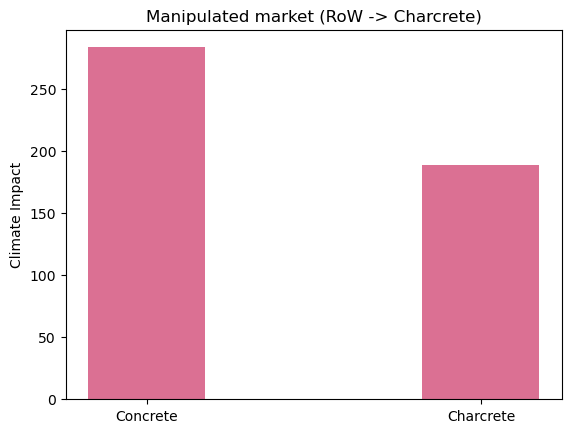

In [88]:
labels = ['Concrete', 'Charcrete']
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

ax.bar(labels, RoW_results, width, color='palevioletred')

ax.set_ylabel('Climate Impact')
ax.set_title('Manipulated market (RoW -> Charcrete)')

plt.show()

In [89]:
fig.savefig(wdir+"/figures/market_concrete_charcrete") 

#### Replacing cement in charcrete

In [94]:
actual_cement = bd.get_activity(database="ei 3.8 cutoff", name="market for cement, Portland", location = "Europe without Switzerland")
best_cement = bd.get_activity(database="ei 3.8 cutoff", name="market for cement, blast furnace slag 81-95%", location = "CH")
worst_cement = bd.get_activity(database="ei 3.8 cutoff", name="market for cement, Portland", location = "ZA")

charcrete_best = replace_stuff(charcrete, actual_cement, best_cement, ipcc)
charcrete_worst = replace_stuff(charcrete, actual_cement, worst_cement, ipcc)

results = [*charcrete_best, charcrete_worst[1]]


In [93]:
charcrete_best
charcrete_worst

(177.64562302249584, 205.7079469509525)

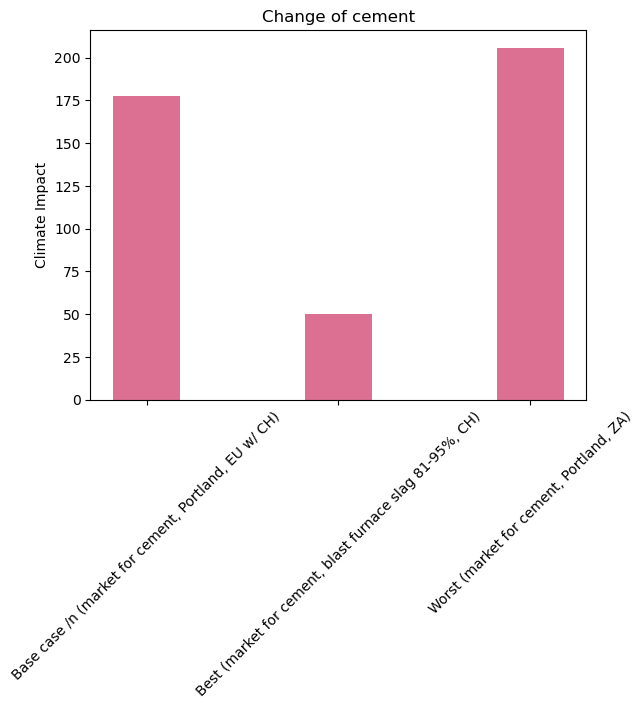

In [99]:
labels = ['Base case (market for cement, Portland, EU w/ CH)', 'Best (market for cement, blast furnace slag 81-95%, CH)', 'Worst (market for cement, Portland, ZA)' ]
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

ax.bar(labels, results, width, color='palevioletred')

ax.set_ylabel('Climate Impact')
ax.set_title('Change of cement')

plt.xticks(rotation=45)

plt.show()

In [100]:
fig.savefig(wdir+"/figures/cement_in_charcrete") 

## Scenarios of charcrete

In [29]:
scenario_df = pd.read_excel(wdir+"/data/Charcrete_database_38.xlsx", sheet_name="scenario")
scenario_df

,Activity name,reference product,location,Charcrete production 5%,Charcrete production 7.5%,Charcrete production 10%,unit,database,type
0,Charcrete production 5%,Charcrete production 5%,SE,1.000,1.000,1.000,cubic meter,Charcrete_38,production
1,Biochar production,Biochar production,SE,0.010,0.015,0.020,ton,Charcrete_38,technosphere
2,"market for gravel, crushed","gravel, crushed",CH,1000.000,1000.000,1000.000,kilogram,ei 3.8 cutoff,technosphere
3,"market for electricity, medium voltage","electricity, medium voltage",SE,5.500,5.500,5.500,kilowatt hour,ei 3.8 cutoff,technosphere
4,market for tap water,tap water,Europe without Switzerland,156.000,156.000,156.000,kilogram,ei 3.8 cutoff,technosphere
5,market for sand,sand,CH,938.000,938.000,938.000,kilogram,ei 3.8 cutoff,technosphere
6,"market for plasticiser, for concrete, based on...","plasticiser, for concrete, based on sulfonated...",GLO,3.200,5.000,6.600,kilogram,ei 3.8 cutoff,technosphere
7,"market for diesel, burned in building machine","diesel, burned in building machine",GLO,0.200,0.200,0.200,MJ,ei 3.8 cutoff,technosphere
8,"market for cement, Portland","cement, Portland",Europe without Switzerland,186.800,180.000,173.400,kilogram,ei 3.8 cutoff,technosphere
9,"Carbon dioxide, to soil or biomass stock",NaN,NaN,3.256,4.884,6.512,kilogram,biosphere3,biosphere


In [30]:
def find_id(x):
    if x["type"] == "technosphere" or x["type"] == "production" :
        try:
            activity = bd.get_activity(database=x["database"], name=x["Activity name"], location=x["location"])
            id_val = activity.id
        except:
            print("erreur : "+x["Activity name"])
    if x["type"] == "biosphere":
            act = bd.get_activity(database="Charcrete_38", name="Charcrete production 5%", location="SE")
            activity = [flow for flow in act.biosphere() if x["Activity name"] in flow["name"]][0]
            id_val = activity.input.id
    return id_val

In [31]:
scenario_df["id"] = scenario_df.apply(find_id, axis=1)
scenario_df

,Activity name,reference product,location,Charcrete production 5%,Charcrete production 7.5%,Charcrete production 10%,unit,database,type,id
0,Charcrete production 5%,Charcrete production 5%,SE,1.000,1.000,1.000,cubic meter,Charcrete_38,production,33105
1,Biochar production,Biochar production,SE,0.010,0.015,0.020,ton,Charcrete_38,technosphere,33104
2,"market for gravel, crushed","gravel, crushed",CH,1000.000,1000.000,1000.000,kilogram,ei 3.8 cutoff,technosphere,15962
3,"market for electricity, medium voltage","electricity, medium voltage",SE,5.500,5.500,5.500,kilowatt hour,ei 3.8 cutoff,technosphere,10117
4,market for tap water,tap water,Europe without Switzerland,156.000,156.000,156.000,kilogram,ei 3.8 cutoff,technosphere,15716
5,market for sand,sand,CH,938.000,938.000,938.000,kilogram,ei 3.8 cutoff,technosphere,5008
6,"market for plasticiser, for concrete, based on...","plasticiser, for concrete, based on sulfonated...",GLO,3.200,5.000,6.600,kilogram,ei 3.8 cutoff,technosphere,6509
7,"market for diesel, burned in building machine","diesel, burned in building machine",GLO,0.200,0.200,0.200,MJ,ei 3.8 cutoff,technosphere,10200
8,"market for cement, Portland","cement, Portland",Europe without Switzerland,186.800,180.000,173.400,kilogram,ei 3.8 cutoff,technosphere,13050
9,"Carbon dioxide, to soil or biomass stock",NaN,NaN,3.256,4.884,6.512,kilogram,biosphere3,biosphere,3891


In [32]:
data = scenario_df[(scenario_df["type"]=="technosphere") | (scenario_df["type"]=="production")][["Charcrete production 5%", "Charcrete production 7.5%", "Charcrete production 10%"]].values.tolist()
t_data_array = np.array(data)
t_data_array

array([[1.000e+00, 1.000e+00, 1.000e+00],
       [1.000e-02, 1.500e-02, 2.000e-02],
       [1.000e+03, 1.000e+03, 1.000e+03],
       [5.500e+00, 5.500e+00, 5.500e+00],
       [1.560e+02, 1.560e+02, 1.560e+02],
       [9.380e+02, 9.380e+02, 9.380e+02],
       [3.200e+00, 5.000e+00, 6.600e+00],
       [2.000e-01, 2.000e-01, 2.000e-01],
       [1.868e+02, 1.800e+02, 1.734e+02]])

In [33]:
[flow for flow in charcrete.biosphere()][0]

Exchange: 3.2560000000000002 kilogram 'Carbon dioxide, to soil or biomass stock' (kilogram, None, ('soil', 'industrial')) to 'Charcrete production 5%' (cubic meter, SE, None)>

In [34]:
ba.print_recursive_supply_chain(charcrete)

1: 'Charcrete production 5%' (cubic meter, SE, None)
  0.01: 'Biochar production' (ton, SE, None)
    0.027: 'Woodchip production' (ton, SE, None)
    0.027: 'Woodchip transport' (ton, SE, None)
    0.027: 'Pyrolysis' (ton, SE, None)
  1e+03: 'market for gravel, crushed' (kilogram, CH, None)
    3.72: 'market for transport, freight train' (ton kilometer, CH, None)
    20.3: 'market for transport, freight, lorry, unspecified' (ton kilometer, RE
    1e+03: 'gravel production, crushed' (kilogram, CH, None)
  5.5: 'market for electricity, medium voltage' (kilowatt hour, SE, None)
    1.03e-07: 'market for transmission network, electricity, medium voltage' (kilome
    6.24e-07: 'market for sulfur hexafluoride, liquid' (kilogram, RER, None)
    5.39: 'electricity voltage transformation from high to medium voltage' (kilo
    0.135: 'electricity, from municipal waste incineration to generic market for 
  156: 'market for tap water' (kilogram, Europe without Switzerland, None)
    9.13e-08: 'ma

In [35]:
ind_list = scenario_df[(scenario_df["type"]=="technosphere") | (scenario_df["type"]=="production")]["id"].values.tolist()
indices = [(ind, 33105) for ind in ind_list]
t_indices = np.array(indices, dtype=bwp.INDICES_DTYPE)

In [36]:
t_flip = np.array([False]+[True for i in range(len(scenario_df[(scenario_df["type"]=="technosphere")]))])
t_flip

array([False,  True,  True,  True,  True,  True,  True,  True,  True])

In [37]:
ind_list = scenario_df[(scenario_df["type"]=="biosphere")]["id"].values.tolist()
indices = [(ind, 33105) for ind in ind_list]
b_indices = np.array(indices, dtype=bwp.INDICES_DTYPE)
b_indices

array([(3891, 33105)], dtype=[('row', '<i4'), ('col', '<i4')])

In [38]:
data = scenario_df[(scenario_df["type"]=="biosphere")][["Charcrete production 5%", "Charcrete production 7.5%", "Charcrete production 10%"]].values.tolist()
b_data = np.array(data)
b_data

array([[3.256, 4.884, 6.512]])

In [39]:
dp_arrays = bwp.create_datapackage(sequential=True, seed=25323) # sequential sampling of columns = [0,1,2,0,1,...]
dp_arrays.add_persistent_array(
    matrix='technosphere_matrix',
    indices_array=t_indices,
    data_array=t_data_array,
    flip_array=t_flip,
)
dp_arrays.add_persistent_array(
    matrix='biosphere_matrix',
    indices_array=b_indices,
    data_array=b_data,
)

In [40]:
charcrete

'Charcrete production 5%' (cubic meter, SE, None)

In [41]:
fu, data_objs, _ = bd.prepare_lca_inputs({charcrete: 1}, method=ipcc)
lca_b = bc.LCA(
    fu,
    data_objs=[*data_objs, dp_arrays],
    use_distributions=False,
    use_arrays=True, 
#     seed_override=42,  # Seed should not be used it randoms the columns order
)
lca_b.lci()
lca_b.lcia()
lca_b.score

177.6456203790934

In [42]:
lca_b.keep_first_iteration()
iterations = 3
scores_b = [lca_b.score for _ in zip(range(iterations), lca_b)]
scores_b

[177.6456203790934, 173.55581965877943, 169.37472971580868]

## Correlated uncertainties

## Sensitivity analysis

In [80]:
%%time
me = bd.Method(ipcc).datapackage()
iterations_mc = 10
seed_mc = 5555  # specifying random seeds is needed for reproducibility of results

# Run MC simulations for all cases
case = "foreground"
fu, data_objs, _ = bd.prepare_lca_inputs({charcrete:1}, method=ipcc)

kr_nounct = data_objs[0].exclude({"kind": "distributions"})
ei_nounct = data_objs[2].exclude({"kind": "distributions"})
char_dp_nounct = data_objs[3].exclude({"kind": "distributions"})
# Case 1: uncertainties are present in both background and foreground
dps_fb = [data_objs[0], data_objs[1], data_objs[2], data_objs[3], me]

# Case 2: uncertainties are present ONLY in FOREground
dps_fg = [kr_nounct, data_objs[1], ei_nounct, data_objs[3], me]

# Case 3: uncertainties are present ONLY in BACKground
dps_bg = [data_objs[0], data_objs[1], data_objs[2], char_dp_nounct, me]

cases = {
    "foreground_background": {"datapackages": dps_fb}, 
    "foreground": {"datapackages": dps_fg}, 
    "background": {"datapackages": dps_bg}
}

CPU times: user 106 ms, sys: 4.39 ms, total: 110 ms
Wall time: 109 ms


In [81]:
lca_mc = bc.LCA(
    fu, 
    data_objs=cases["background"]["datapackages"],
    use_distributions=True, 
    seed_override=seed_mc,
)
lca_mc.lci()
lca_mc.lcia()

# Run Monte Carlo simulations
lca_scores_mc = []
for i in range(iterations_mc):
        next(lca_mc)
        lca_scores_mc.append(lca_mc.score)
lca_scores_mc

[179.6214846430216,
 143.03497693060976,
 155.49699000009073,
 220.0485003346507,
 169.1094064501976,
 156.3502609500023,
 171.5504956914105,
 155.12110725302344,
 194.43024216021212,
 184.108094601519]

In [82]:
%%time

iterations_mc = 1000
seed_mc = 5555  # specifying random seeds is needed for reproducibility of results

# Run MC simulations for all cases
for case, dict_ in cases.items():
    print(case)
    dps = dict_["datapackages"]
    lca_mc = bc.LCA(
        {charcrete.id: 1}, 
        data_objs=dps,
        use_distributions=True, 
        seed_override=seed_mc,
    )
    lca_mc.lci()
    lca_mc.lcia()

    # Since MC takes time, make sure to save the results!
    # Also, read lca_scores from file if you already computed them once
    output_dir = Path(wdir+"/outputs")
    fp_mc = output_dir / f'lca_scores_{seed_mc}_{iterations_mc}_{case}.json'
    replace = True
    if replace == False:
        # Read LCIA scores
        with open(fp_mc, 'r') as f:
            lca_scores_mc = json.load(f)
    else:
        # Run Monte Carlo simulations
        lca_scores_mc = []
        for i in range(iterations_mc):
            next(lca_mc)
            lca_scores_mc.append(lca_mc.score)
        print("Save LCIA scores")
        with open(fp_mc, 'w') as f:
            json.dump(lca_scores_mc, f)

    dict_['lca_scores_mc'] = lca_scores_mc
    

foreground_background
Save LCIA scores
foreground
Save LCIA scores
background
Save LCIA scores
CPU times: user 1min 42s, sys: 1.16 s, total: 1min 44s
Wall time: 26.8 s


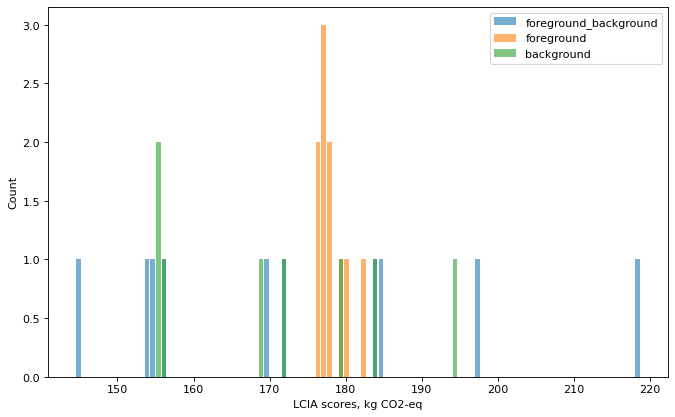

In [83]:
num_bins = 100
lca_scores_mc_all = np.hstack([dict_['lca_scores_mc'] for dict_ in cases.values()])
lca_scores_mc_all = lca_scores_mc_all[
    np.logical_and(
        lca_scores_mc_all > np.percentile(lca_scores_mc_all, 0),
        lca_scores_mc_all < np.percentile(lca_scores_mc_all, 99),
    )
]
bins = np.linspace(min(lca_scores_mc_all), max(lca_scores_mc_all), num_bins, endpoint=True)
midbins = (bins[:-1] + bins[1:]) / 2
width = (bins[1]-bins[0])*0.8

plt.figure(figsize=(10, 6), dpi=80)

# Uncertainty distributions for all cases
for case, dict_ in cases.items():
    lca_scores_mc = dict_['lca_scores_mc']
    freq, _ = np.histogram(lca_scores_mc, bins=bins, density=False)
    plt.bar(midbins, freq, width=width, label=case, alpha=0.6)

plt.xlabel("LCIA scores, kg CO2-eq")
plt.ylabel("Count")
plt.legend(loc="upper right")

In [1]:
lca_scores_mc_all

NameError: name 'lca_scores_mc_all' is not defined